In [1]:
import torch
from SVI_solver_library.transform.AdapterTransform import AdapterTransform as Adapter
from SVI_solver_library.solver.ProjSolver import ProjSolver as ProjSolver

In [2]:
def P_X(u, l, h):
    return torch.where(u < l, l, torch.where(u > h, h, u))

In [3]:
def P_ex(u):
    return P_X(u, torch.tensor([1, 0, 0, 1], dtype=torch.double), 100)

In [4]:
def F_ex(u):
    return torch.tensor([3*u[0] - 1/(u[0] + 0.1) + 3*u[1] - 2,
                  3*u[0] + 3 * u[1],
                  4*u[2] + 3*u[3],
                  4*u[2] + 4*u[3] - 1 / (u[3] + 0.1) - 3],dtype=torch.double)

In [5]:
F = Adapter(F_ex)
P = Adapter(P_ex)
Ex_solver = ProjSolver(F, torch.tensor([4, 4, 4, 4], dtype=torch.double), P = P)
u_ex = torch.rand(4, dtype=torch.double)
answer, verbose = Ex_solver.solve(u_ex)

In [13]:
F_ex(u_ex)

tensor([0.0897, 2.9992, 3.0002, 0.0894], dtype=torch.float64)

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]

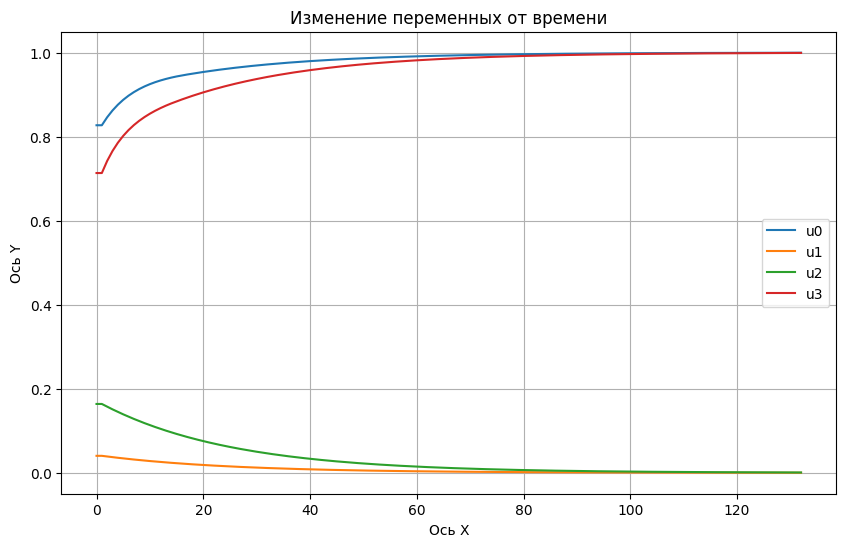

In [8]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='u0')  
plt.plot(u1_history.numpy(), label='u1')  
plt.plot(u2_history.numpy(), label='u2') 
plt.plot(u3_history.numpy(), label='u3') 


plt.title('Изменение переменных от времени')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')
plt.legend()
plt.grid(True) 

plt.show()

In [45]:
def project(x, C):
    norm = np.linalg.norm(x)
    if norm > 1:
        return x / norm
    return x

In [46]:
def P_ex1(u):
    return project(u, 1)

In [47]:
def F_ex1(u):
    return 4*u**3 - 4*u

In [48]:
F_1 = Adapter(F_ex1)
P_1 = Adapter(P_ex1)
Ex_solver = ProjSolver(F_1, torch.tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=torch.double), P = P_1)
u_ex = torch.rand(10, dtype=torch.double)
answer, verbose = Ex_solver.solve(u_ex)

In [49]:
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]
u4_history = verbose[:, 4]
u5_history = verbose[:, 5]
u6_history = verbose[:, 6]
u7_history = verbose[:, 7]
u8_history = verbose[:, 8]
u9_history = verbose[:, 9]

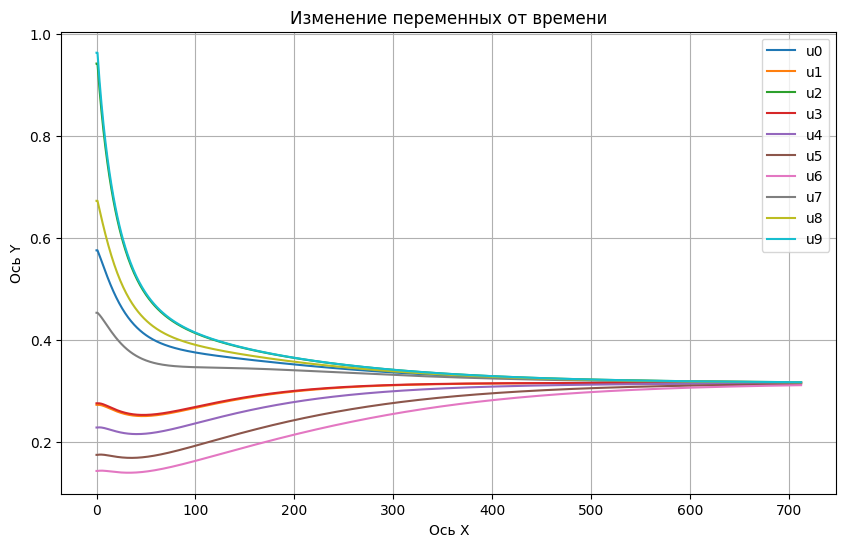

In [50]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='u0')  
plt.plot(u1_history.numpy(), label='u1')  
plt.plot(u2_history.numpy(), label='u2') 
plt.plot(u3_history.numpy(), label='u3') 
plt.plot(u4_history.numpy(), label='u4') 
plt.plot(u5_history.numpy(), label='u5') 
plt.plot(u6_history.numpy(), label='u6') 
plt.plot(u7_history.numpy(), label='u7') 
plt.plot(u8_history.numpy(), label='u8') 
plt.plot(u9_history.numpy(), label='u9') 


plt.title('Изменение переменных от времени')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')
plt.legend()
plt.grid(True) 

plt.show()

In [51]:
answer

tensor([0.3176, 0.3163, 0.3178, 0.3163, 0.3156, 0.3139, 0.3120, 0.3173, 0.3177,
        0.3178], dtype=torch.float64)

In [52]:
import numpy as np
import time

def f(x):
    return np.sum(x**4 - 2*x**2)

def G(x):
    return 4*x**3 - 4*x

def J(x):
    return np.diag(12*x**2 - 4)

def project(x, C):
    norm = np.linalg.norm(x)
    if norm > C:
        return x / norm
    return x

def variational_inequality(G, x, C, max_iter=1000, tol=1e-5):
    iter_count = 0
    for _ in range(max_iter):
        iter_count += 1
        x_new = project(x - G(x), C)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x, iter_count

def newton_method(G, J, x0, C, max_iter=1000, tol=1e-10):
    x = x0
    iter_count = 0
    for _ in range(max_iter):
        iter_count += 1
        J_inv = np.linalg.inv(J(x))
        dx = -np.dot(J_inv, G(x))
        x_new = project(x + dx, C)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x, iter_count

def extragradient_method(G, x0, C, learning_rate=0.1, max_iter=1000, tol=1e-5):
    x = x0
    iter_count = 0
    for _ in range(max_iter):
        iter_count += 1
        y = project(x - learning_rate * G(x), C)
        x_new = project(x - learning_rate * G(y), C)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x, iter_count

def phi_alpha(G, x, alpha, C):
    def Phi_alpha(x, y):
        return np.dot(G(x), x - y) - (1 / (2 * alpha)) * np.linalg.norm(x - y)**2

    def y_alpha(x):
        y = x - alpha * G(x)
        norm_y = np.linalg.norm(y)
        if norm_y > C:
            y = y / norm_y
        return y

    y_alpha_x = y_alpha(x)
    return Phi_alpha(x, y_alpha_x)

def interval_descent(G, J, x0, alpha, beta, gamma, C, max_iter=1000, tol=1e-5):
    x = x0
    iter_count = 0
    for k in range(max_iter):
        iter_count += 1
        y_alpha_x = x - alpha * G(x)
        norm_y = np.linalg.norm(y_alpha_x)
        if norm_y > C:
            y_alpha_x = y_alpha_x / norm_y
        dk = y_alpha_x - x
        if np.linalg.norm(dk) < tol:
            break
        m = 1
        while phi_alpha(G, x + gamma**m * dk, alpha, C) > phi_alpha(G, x, alpha, C) - beta * gamma**m * np.linalg.norm(dk)**2 and m < 2:
            m += 1
        lambda_k = gamma**m
        x = x + lambda_k * dk
    return x, iter_count


n = 2  # Размерность задачи
x0 = np.random.rand(n)
C = 1  # Радиус шара
alpha = 0.1
beta = 0.5
gamma = 0.5

# Проективный метод
start_time = time.time()
solution_proj, iter_count_proj = variational_inequality(G, x0, C)
proj_time = time.time() - start_time

# Метод Ньютона
start_time = time.time()
solution_newton, iter_count_newton = newton_method(G, J, x0, C)
newton_time = time.time() - start_time

# Экстраградиентный метод
start_time = time.time()
solution_extra, iter_count_extra = extragradient_method(G, x0, C)
extra_time = time.time() - start_time

# Метод спуска по интервальной функции
start_time = time.time()
solution_interval, iter_count_interval = interval_descent(G, J, x0, alpha, beta, gamma, C)
interval_time = time.time() - start_time

start_time = time.time()
Ex_solver = ProjSolver(Adapter(F_ex1), P=Adapter(P_ex1))
u_ex = torch.rand(n, dtype=torch.double)
solution_solver= Ex_solver.solve(u_ex)
solver_time = time.time() - start_time

# Вывод результатов
print(f"Проективный метод: Время выполнения = {proj_time:.5f} сек, Количество итераций = {iter_count_proj}, Решение = {solution_proj}, Значение = {f(solution_proj)}")
print(f"Метод Ньютона: Время выполнения = {newton_time:.5f} сек, Количество итераций = {iter_count_newton}, Решение = {solution_newton}, Значение = {f(solution_newton)}")
print(f"Экстраградиентный метод: Время выполнения = {extra_time:.5f} сек, Количество итераций = {iter_count_extra}, Решение = {solution_extra}, Значение = {f(solution_extra)}")
print(f"Метод спуска по интервальной функции: Время выполнения = {interval_time:.5f} сек, Количество итераций = {iter_count_interval}, Решение = {solution_interval}, Значение = {f(solution_interval)}")
print(f"Метод нейронной сети: Время выполнения = {solver_time:.5f} сек, Решение = {solution_solver[0]}, Значение = {f(solution_solver[0].detach().numpy())}")

Проективный метод: Время выполнения = 0.00000 сек, Количество итераций = 13, Решение = [0.7071089  0.70710467], Значение = -1.4999999999821172
Метод Ньютона: Время выполнения = 0.00050 сек, Количество итераций = 4, Решение = [-3.8604543e-16  0.0000000e+00], Значение = -2.9806214821224744e-31
Экстраградиентный метод: Время выполнения = 0.00100 сек, Количество итераций = 37, Решение = [0.7071265  0.70708706], Значение = -1.4999999984444297
Метод спуска по интервальной функции: Время выполнения = 0.00553 сек, Количество итераций = 80, Решение = [0.70712728 0.70708628], Значение = -1.499999998199173
Метод нейронной сети: Время выполнения = 0.02611 сек, Решение = tensor([0.7054, 0.7065], dtype=torch.float64), Значение = -1.4966392798981407


In [53]:
from SVI_solver_library.integrator.EulerIntegrator import EulerIntegrator

integrator = EulerIntegrator(dt=0.1, max_iter=200, max_dif=0.001)

In [54]:
def test(n, results_dict):
    x0 = np.random.rand(n)
    u_ex = torch.tensor(x0, dtype=torch.double)
    C = 1  # Радиус шара
    alpha = 0.1
    beta = 0.5
    gamma = 0.5

    values = []

    start_time = time.time()
    solution_proj, iter_count_proj = variational_inequality(G, x0, C)
    proj_time = time.time() - start_time
    value_proj = f(solution_proj)
    values.append(value_proj)
    iters_proj.append(iter_count_proj)
    times_proj.append(proj_time)
    solutions_proj.append(f(solution_proj))

    start_time = time.time()
    solution_newton, iter_count_newton = newton_method(G, J, x0, C)
    newton_time = time.time() - start_time
    value_newton = f(solution_newton)
    values.append(value_newton)
    iters_newton.append(iter_count_newton)
    times_newton.append(newton_time)
    solutions_newton.append(f(solution_newton))

    start_time = time.time()
    solution_extra, iter_count_extra = extragradient_method(G, x0, C)
    extra_time = time.time() - start_time
    value_extra = f(solution_extra)
    values.append(value_extra)
    iters_extra.append(iter_count_extra)
    times_extra.append(extra_time)
    solutions_extra.append(f(solution_extra))

    start_time = time.time()
    solution_interval, iter_count_interval = interval_descent(G, J, x0, alpha, beta, gamma, C)
    value_interval = f(solution_interval)
    values.append(value_interval)
    interval_time = time.time() - start_time
    iters_interval.append(iter_count_interval)
    times_interval.append(interval_time)
    solutions_interval.append(f(solution_interval))


    Ex_solver = ProjSolver(Adapter(F_ex1), P=Adapter(P_ex1), integrator=integrator)
    start_time = time.time()
    solution_neuro, verbose = Ex_solver.solve(u_ex)
    verboses.append(verbose)
    solutions_neuro.append(f(solution_neuro.detach().numpy()))
    value_neuro = f(solution_neuro.detach().numpy())
    values.append(value_neuro)
    neuro_time = time.time() - start_time
    times_neuro.append(time.time() - start_time)
    iters_neuro.append(len(verbose))

    best_value = min(values)

    methods = [
        ("Проекция", solution_proj, value_proj, proj_time, iter_count_proj),
        ("Ньютон", solution_newton, value_newton, newton_time, iter_count_newton),
        ("Экстраградиент", solution_extra, value_extra, extra_time, iter_count_extra),
        ("Интервальный спуск", solution_interval, value_interval, interval_time, iter_count_interval),
        ("Нейросетевой", solution_neuro.detach().numpy(), value_neuro, neuro_time, len(verbose))
    ]

    for method_name, solution, value, time_taken, iterations in methods:
        residual = abs(value - best_value)
        results_dict['Имя метода'].append(method_name)
        results_dict['Размерность'].append(n)
        results_dict['Значение'].append(value)
        results_dict['Невязка'].append(residual)
        results_dict['Время'].append(time_taken)
        results_dict['Количество_итераций'].append(iterations)

In [55]:
import numpy as np
import time
import matplotlib.pyplot as plt

# ... (Your existing code for functions f, G, J, project, variational_inequality, etc.)
iters_proj = []
iters_newton = []
iters_extra = []
iters_interval = []
iters_neuro = []
times_proj = []
times_newton = []
times_extra = []
times_interval = []
times_neuro = []
solutions_proj = []
solutions_newton = []
solutions_extra = []
solutions_interval = []
solutions_neuro = []
verboses = []

results_dict = {'Имя метода': [], 'Размерность' : [], 'Значение' : [], 'Невязка': [], 'Время': [], 'Количество_итераций': []}


for n in range(1, 11):
    test(n, results_dict)

In [56]:
verbose = verboses[9]
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]
u4_history = verbose[:, 4]
u5_history = verbose[:, 5]
u6_history = verbose[:, 6]
u7_history = verbose[:, 7]
u8_history = verbose[:, 8]
u9_history = verbose[:, 9]

In [57]:
verbose = verboses[1]
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]

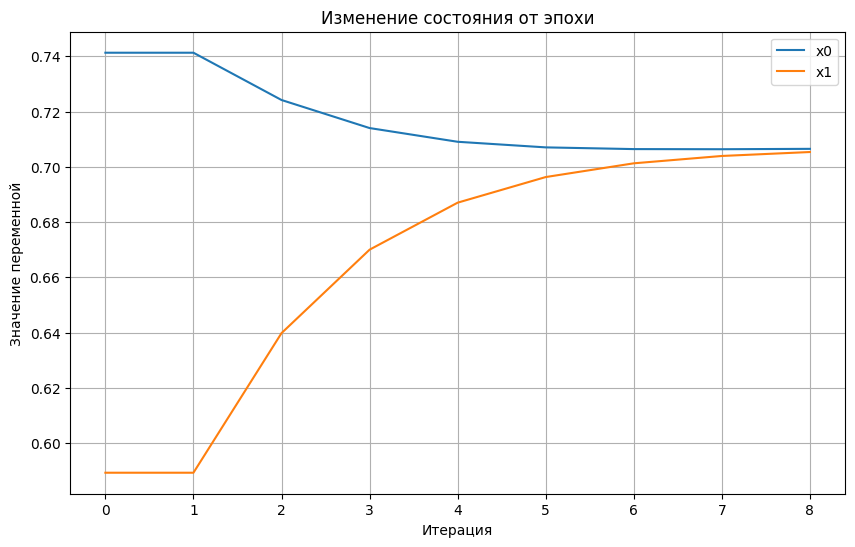

In [58]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='x0')  
plt.plot(u1_history.numpy(), label='x1')  


plt.title('Изменение состояния от эпохи')
plt.xlabel('Итерация')
plt.ylabel('Значение переменной')
plt.legend()
plt.grid(True) 

plt.show()

In [59]:
verbose = verboses[2]
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]

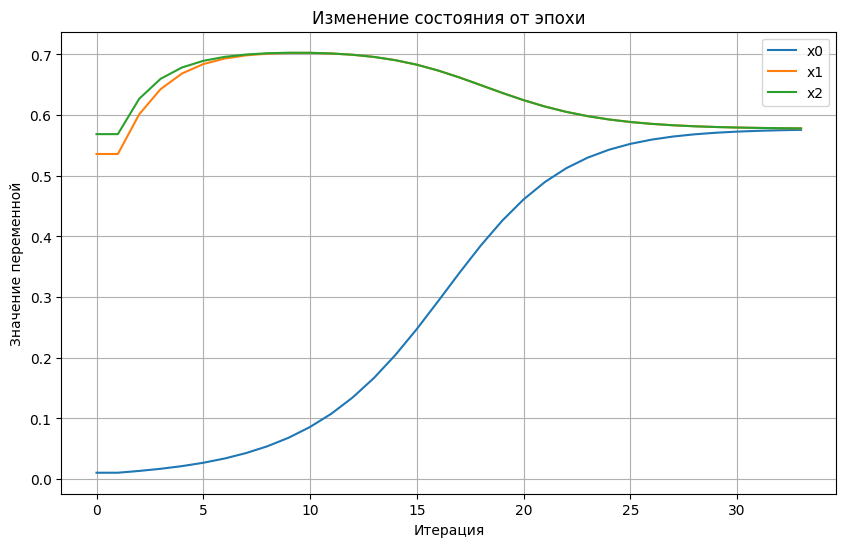

In [60]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='x0')  
plt.plot(u1_history.numpy(), label='x1')  
plt.plot(u2_history.numpy(), label='x2')  


plt.title('Изменение состояния от эпохи')
plt.xlabel('Итерация')
plt.ylabel('Значение переменной')
plt.legend()
plt.grid(True) 

plt.show()

In [61]:
verbose = verboses[3]
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]

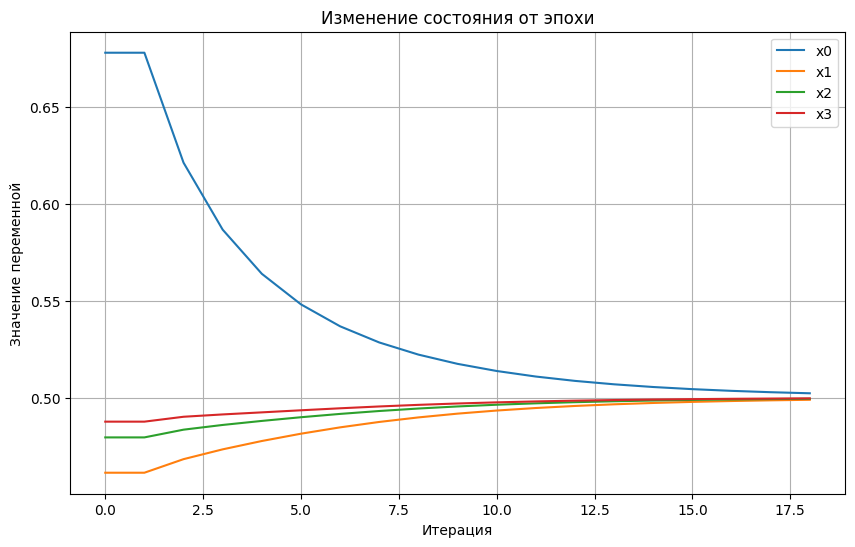

In [62]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='x0')  
plt.plot(u1_history.numpy(), label='x1')  
plt.plot(u2_history.numpy(), label='x2')  
plt.plot(u3_history.numpy(), label='x3')  


plt.title('Изменение состояния от эпохи')
plt.xlabel('Итерация')
plt.ylabel('Значение переменной')
plt.legend()
plt.grid(True) 

plt.show()

In [63]:
verbose = verboses[9]
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]
u4_history = verbose[:, 4]
u5_history = verbose[:, 5]
u6_history = verbose[:, 6]
u7_history = verbose[:, 7]
u8_history = verbose[:, 8]
u9_history = verbose[:, 9]

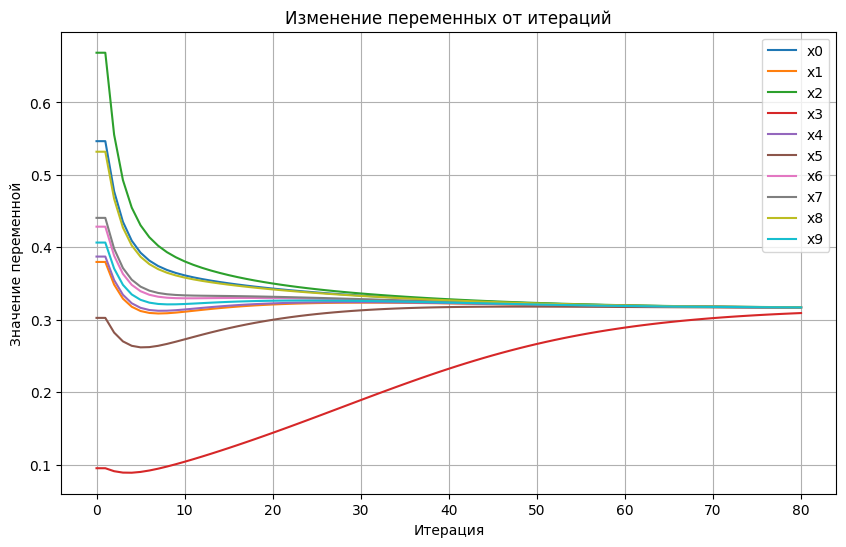

In [64]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='x0')  
plt.plot(u1_history.numpy(), label='x1')  
plt.plot(u2_history.numpy(), label='x2') 
plt.plot(u3_history.numpy(), label='x3') 
plt.plot(u4_history.numpy(), label='x4') 
plt.plot(u5_history.numpy(), label='x5') 
plt.plot(u6_history.numpy(), label='x6') 
plt.plot(u7_history.numpy(), label='x7') 
plt.plot(u8_history.numpy(), label='x8') 
plt.plot(u9_history.numpy(), label='x9') 


plt.title('Изменение переменных от итераций')
plt.xlabel('Итерация')
plt.ylabel('Значение переменной')
plt.legend()
plt.grid(True) 

plt.show()

In [ ]:
from IPython.display import display

In [ ]:
import pandas as pd

results_df = pd.DataFrame(results_dict)
grouped = results_df.groupby('Размерность')

# Пример: вывод сгруппированных данных
for dimension, group in grouped:
    display(pd.DataFrame(group))
    test = group
    print("\n")

,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
0,Проекция,1,-1.000000,0.000000e+00,0.000000,2
1,Ньютон,1,-1.000000,0.000000e+00,0.000000,2
2,Экстраградиент,1,-1.000000,1.402306e-08,0.000999,45
3,Интервальный спуск,1,-1.000000,4.631480e-10,0.003000,26
4,Нейросетевой,1,-0.999996,4.204318e-06,0.003001,12


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
5,Проекция,2,-1.50000,0.00191,0.000,11
6,Ньютон,2,-1.00000,0.50191,0.000,5
7,Экстраградиент,2,-1.50000,0.00191,0.001,28
8,Интервальный спуск,2,-1.50000,0.00191,0.006,59
9,Нейросетевой,2,-1.50191,0.00000,0.001,7


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
10,Проекция,3,-1.666667,0.000645,0.000999,11
11,Ньютон,3,-1.000000,0.667312,0.000000,7
12,Экстраградиент,3,-1.666667,0.000645,0.000000,39
13,Интервальный спуск,3,-1.666667,0.000645,0.006998,94
14,Нейросетевой,3,-1.667312,0.000000,0.002000,14


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
15,Проекция,4,-1.750000,0.000000e+00,0.000000,17
16,Ньютон,4,-1.000000,7.500000e-01,0.000000,6
17,Экстраградиент,4,-1.750000,3.087072e-09,0.000999,55
18,Интервальный спуск,4,-1.750000,3.969888e-09,0.007001,135
19,Нейросетевой,4,-1.749989,1.065837e-05,0.004001,27


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
20,Проекция,5,-1.80000,0.000000e+00,0.000000,28
21,Ньютон,5,-1.00000,8.000000e-01,0.000000,7
22,Экстраградиент,5,-1.80000,3.318454e-09,0.001001,76
23,Интервальный спуск,5,-1.80000,4.942589e-09,0.008998,194
24,Нейросетевой,5,-1.79999,1.049744e-05,0.007004,45


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
25,Проекция,6,-1.833333,0.000000e+00,0.000000,27
26,Ньютон,6,-1.000000,8.333333e-01,0.000000,7
27,Экстраградиент,6,-1.833333,3.575408e-09,0.000997,76
28,Интервальный спуск,6,-1.833333,5.863084e-09,0.008999,194
29,Нейросетевой,6,-1.833322,1.151384e-05,0.006002,38


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
30,Проекция,7,-1.857143,0.000000e+00,0.000000,31
31,Ньютон,7,-1.000000,8.571429e-01,0.001000,7
32,Экстраградиент,7,-1.857143,4.065951e-09,0.000999,83
33,Интервальный спуск,7,-1.857143,6.764591e-09,0.008999,209
34,Нейросетевой,7,-1.857133,1.021126e-05,0.006002,42


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
35,Проекция,8,-1.87500,0.000000e+00,0.000000,38
36,Ньютон,8,-1.00000,8.750000e-01,0.001000,5
37,Экстраградиент,8,-1.87500,4.963684e-09,0.000998,97
38,Интервальный спуск,8,-1.87500,8.243705e-09,0.011000,246
39,Нейросетевой,8,-1.87499,1.033932e-05,0.007002,52


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
40,Проекция,9,-1.888889,0.000000e+00,0.001000,69
41,Ньютон,9,-1.000000,8.888889e-01,0.000000,7
42,Экстраградиент,9,-1.888889,5.097289e-09,0.001998,167
43,Интервальный спуск,9,-1.888889,8.945459e-09,0.030999,540
44,Нейросетевой,9,-1.888871,1.829730e-05,0.016003,119


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
45,Проекция,10,-1.900000,0.000000e+00,0.001000,54
46,Ньютон,10,-1.000000,9.000000e-01,0.000000,6
47,Экстраградиент,10,-1.900000,6.319725e-09,0.002001,132
48,Интервальный спуск,10,-1.900000,9.987214e-09,0.019001,375
49,Нейросетевой,10,-1.899987,1.331283e-05,0.010998,79


In [ ]:
result = results_df.groupby('Имя метода').mean().reset_index()

display(result)

,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
0,Интервальный спуск,5.5,-1.707103,0.000255,0.011099,207.2
1,Нейросетевой,5.5,-1.707350,0.000009,0.006301,43.5
2,Ньютон,5.5,-1.000000,0.707359,0.000200,5.9
3,Проекция,5.5,-1.707103,0.000255,0.000300,28.8
4,Экстраградиент,5.5,-1.707103,0.000255,0.001099,79.8


Text(0, 0.5, 'Итерации')

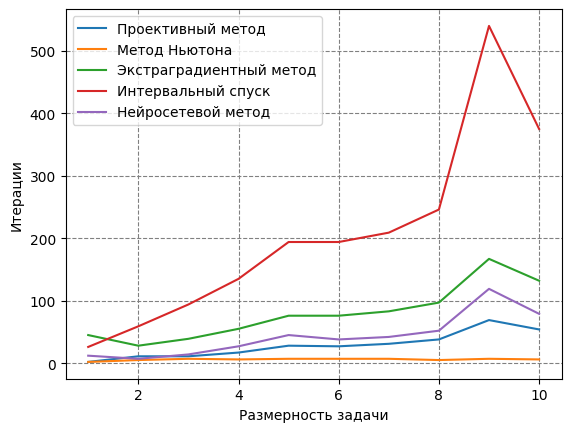

In [ ]:
plt.grid(color='gray', linestyle='dashed')
plt.plot(range(1, 11), iters_proj, label='Проективный метод')
plt.plot(range(1, 11), iters_newton, label='Метод Ньютона')
plt.plot(range(1, 11), iters_extra, label='Экстраградиентный метод')
plt.plot(range(1, 11), iters_interval, label='Интервальный спуск')
plt.plot(range(1, 11), iters_neuro, label='Нейросетевой метод')
plt.legend()
plt.xlabel('Размерность задачи')
plt.ylabel('Итерации')

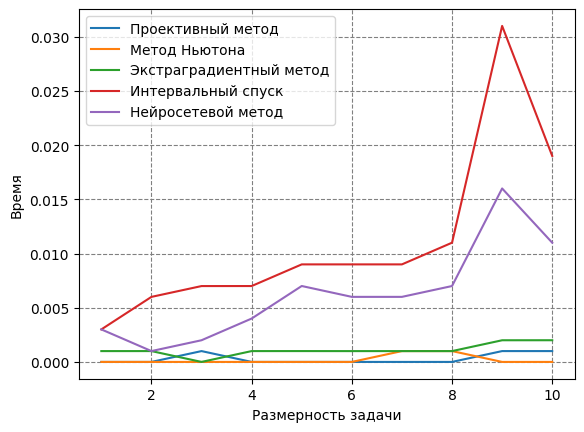

In [ ]:
plt.grid(color='gray', linestyle='dashed')
plt.plot(range(1, 11), times_proj, label='Проективный метод')
plt.plot(range(1, 11), times_newton, label='Метод Ньютона')
plt.plot(range(1, 11), times_extra, label='Экстраградиентный метод')
plt.plot(range(1, 11), times_interval, label='Интервальный спуск')
plt.plot(range(1, 11), times_neuro, label='Нейросетевой метод')
plt.xlabel('Размерность задачи')
plt.ylabel('Время')
plt.legend(loc='upper left')

In [ ]:
results_df['Невязка'] = results_df['Невязка'].astype(float)

# Группируем по методу и извлекаем значения невязки
residuals = results_df.groupby('Имя метода')['Невязка'].apply(list).reset_index()

# Преобразуем результат в список
residuals_list = residuals['Невязка'].tolist()

print(residuals_list[0])

[4.6314796442459283e-10, 0.0019096558030091693, 0.000645123653263191, 3.969887751864576e-09, 4.942589226786254e-09, 5.863083574197958e-09, 6.764591331531733e-09, 8.243705496013831e-09, 8.945458596087974e-09, 9.987214166784497e-09]


In [ ]:
residuals

,Имя метода,Невязка
0,Интервальный спуск,"[4.6314796442459283e-10, 0.0019096558030091693..."
1,Нейросетевой,"[4.2043183976492315e-06, 0.0, 0.0, 1.065836962..."
2,Ньютон,"[0.0, 0.5019096544219142, 0.6673117873409669, ..."
3,Проекция,"[0.0, 0.0019096544749674926, 0.000645120767928..."
4,Экстраградиент,"[1.4023062044898893e-08, 0.001909656017834438,..."


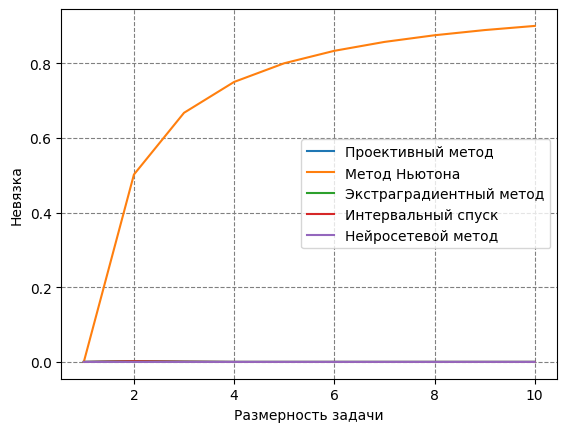

In [ ]:
plt.rc('axes', axisbelow=True)
plt.plot(range(1, 11), residuals_list[3], label='Проективный метод')
plt.plot(range(1, 11), residuals_list[2], label='Метод Ньютона')
plt.plot(range(1, 11), residuals_list[4], label='Экстраградиентный метод')
plt.plot(range(1, 11), residuals_list[0], label='Интервальный спуск')
plt.plot(range(1, 11), residuals_list[1], label='Нейросетевой метод')
plt.xlabel('Размерность задачи')
plt.ylabel('Невязка')
plt.legend()
plt.grid(color='gray', linestyle='dashed')